In [1]:
!pip install scanpy
!pip install KDEpy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau
    


import importlib

In [3]:
import sys
import os
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

ModuleNotFoundError: No module named 'tools'

### Read data

In [ ]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_nb_est.h5ad")


## Correlation scaling

In [12]:
# Calculate mean ratio
# cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
# cor_gen = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_orig = np.corrcoef(data_gene.layers["counts"].toarray())
cor_gen = np.corrcoef(data_null_gen.X)
cor_ratio = np.mean(cor_orig)/np.mean(cor_gen)
print(cor_ratio)


1.0903341789539216


In [19]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen2, R_est2 = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True, correct_var=True, return_R=True, corr_factor=1, R_est=None, check_pd=True)
data_null_gen2

AnnData object with n_obs × n_vars = 1544 × 5553

In [20]:
data_null_gen_new, R_est_new = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True, correct_var=True, return_R=True, corr_factor=1.5, R_est=R_est, check_pd=True)
data_null_gen_new

/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:248: UserWarning: R_est is not positive definite! Adjusting eigenvalues...
  warnings.warn("R_est is not positive definite! Adjusting eigenvalues...")


AnnData object with n_obs × n_vars = 1544 × 5553

In [21]:
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
cor_gen = cd.schaefer_strimmer(data_null_gen_new.X, use_corr=True)

large_cor = (np.abs(cor_orig) > 0.1) | (np.abs(cor_gen) > 0.1)
frob = np.linalg.norm(cor_orig[large_cor] - cor_gen[large_cor])
print(frob)

/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:287: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


415.2328991982995


In [28]:
from scipy.optimize import golden
importlib.reload(cd)

def opt_fun(factor):
    data_null_gen2, R_est_new = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True, correct_var=True, return_R=True, corr_factor=factor, R_est=R_est)
    cor_gen = cd.schaefer_strimmer(data_null_gen2.X, use_corr=True)

    large_cor = (np.abs(cor_orig) > 0.1) | (np.abs(cor_gen) > 0.1)
    frob = np.linalg.norm(cor_orig[large_cor] - cor_gen[large_cor])
    if np.isnan(frob):
        frob = np.inf
    return frob

In [29]:
importlib.reload(cd)
xmin, fval, funcalls = golden(opt_fun, brack=(1, 2), full_output=True, maxiter=3)

/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:248: UserWarning: R_est is not positive definite! Adjusting eigenvalues...
  warnings.warn("R_est is not positive definite! Adjusting eigenvalues...")
/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:287: RuntimeWarning: invalid value encountered in divide
  X_st = np.nan_to_num(X / np.std(X, axis=0), nan=0)
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/johannes.ostner/opt/anaconda3/envs/BacSC/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/johannes.ostner/Documents/PhD/BacSC/tools/ClusterDE.py:248: UserWarning: R_est is not positive definite! Adjusting eigenvalues...
  warnings.warn("R_est is not positive definite! Adjusting eigenvalues...")
/Users/johannes.ostner/Documents

In [30]:
print(xmin)
print(fval)
print(funcalls)

1.14589803279532
286.5805205669762
8


In [31]:
importlib.reload(cd)
data_null_gen_opt, R_est_opt = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto", auto_dist=True, correct_var=True, return_R=True, corr_factor=xmin, R_est=R_est2)
data_null_gen_opt

AnnData object with n_obs × n_vars = 1544 × 5553

In [32]:
data_null_gen_opt.var_names = data_gene.var_names
sc.pp.calculate_qc_metrics(data_null_gen_opt)
data_null_gen_opt.var["var_counts"] = np.asarray(np.var(data_null_gen_opt.X, axis=0)).squeeze()
data_null_gen_opt.var["mean_counts"] = np.asarray(np.mean(data_null_gen_opt.X, axis=0)).squeeze()

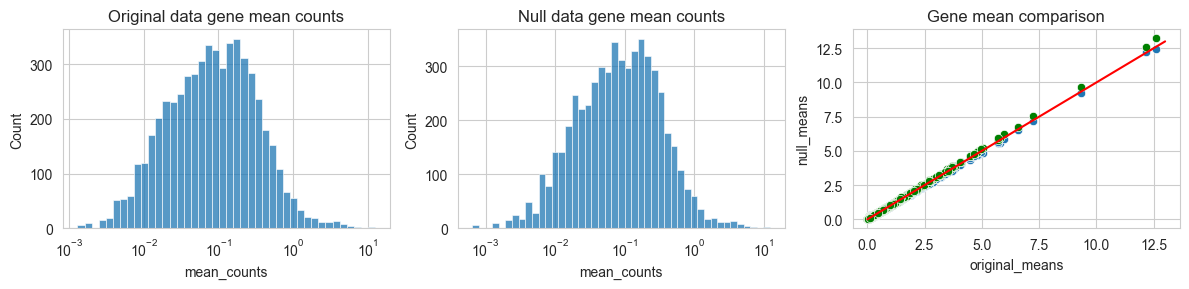

SignificanceResult(statistic=0.9963622344136609, pvalue=0.0)


In [33]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen_opt.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene.var["mean_counts"], "null_means": data_null_gen_opt.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
sns.scatterplot(mean_df, y="null_means", x="original_means", ax=ax[2], color="green")
ax[2].plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

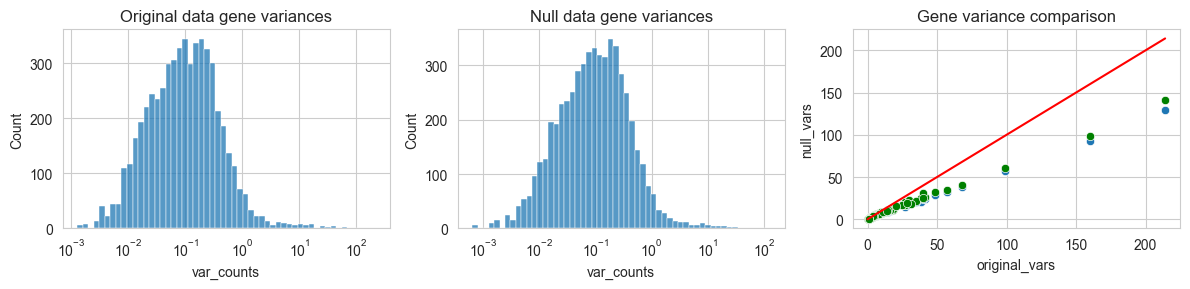

SignificanceResult(statistic=0.9945696712383469, pvalue=0.0)
[[1.         0.99735809]
 [0.99735809 1.        ]]


In [34]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen_opt.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene.var["var_counts"], "null_vars": data_null_gen_opt.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])
g = sns.scatterplot(var_df, y="null_vars", x="original_vars", ax=ax[2], color="green")

# g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene.var["var_counts"]))], [0, np.ceil(np.max(data_gene.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

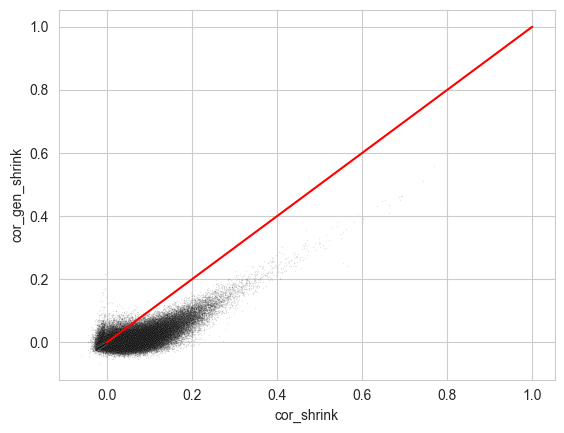

In [35]:
cor_shrink = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene.var_names, columns=data_gene.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen_opt.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene.var_names, columns=data_gene.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.show()

In [36]:
# cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
# cor_gen = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_orig = np.corrcoef(data_gene.layers["counts"].toarray())
cor_gen = np.corrcoef(data_null_gen_opt.X)
cor_ratio = np.mean(cor_orig)/np.mean(cor_gen)
print(cor_ratio)

1.1168623421695199


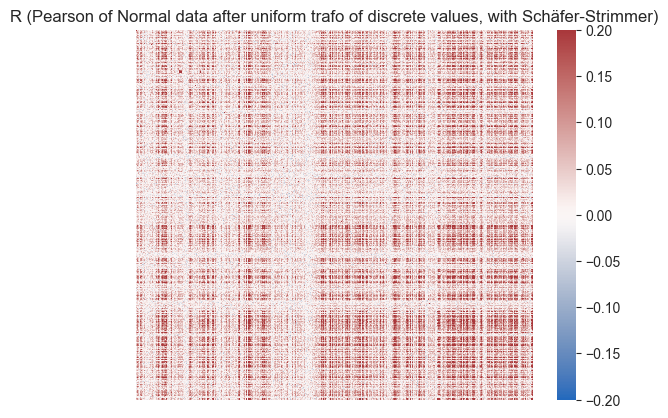

In [37]:
sns.heatmap(R_est_opt,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("R (Pearson of Normal data after uniform trafo of discrete values, with Schäfer-Strimmer)")
plt.show()